Simple example of single-window 4Dvar assimilation on the Lorenz-96 system.

The system state is composed of $N$ variables $x_1, ..., x_N$ with periodic boundaries (i.e. $x_{N+1} = x_{1}, x_{0} = x_N, x_{-1} = x_{N-1}$).

For $i=1, ..., N$, its evolution is described by:

$\frac{dx_i}{dt} = (x_{i+1} - x_{i-2}) x_{i-1} - x_i + F$

We will use the most common choices $N=40$ and $F=8$.

In [ ]:
import os
import torch
from matplotlib import pyplot as plt
from time import time
from tensordict import TensorDict
from mdml_sim.lorenz96 import L96Simulator
os.chdir('..')
from da_tools.variational.hard_constraint_4dvar import hc4dvar_single_window
from da_tools.system.state import State
from da_tools.observation.operators import random_sparse_noisy_obs
from da_tools.util.initialization import naive_initialization
from da_tools.util.visualization import show_1dseqimg

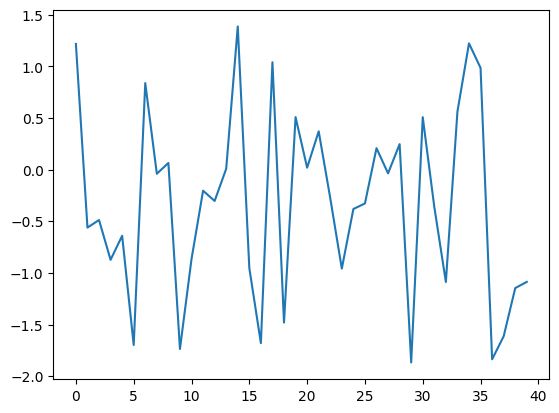

In [ ]:
# Define a target initial state
n_variables = 40 # N = 40
initial_state = State(torch.randn(1, 1, n_variables))  # (batch, time, n_variables)
plt.plot(initial_state.fields['x'].squeeze())

torch.Size([1000, 40])


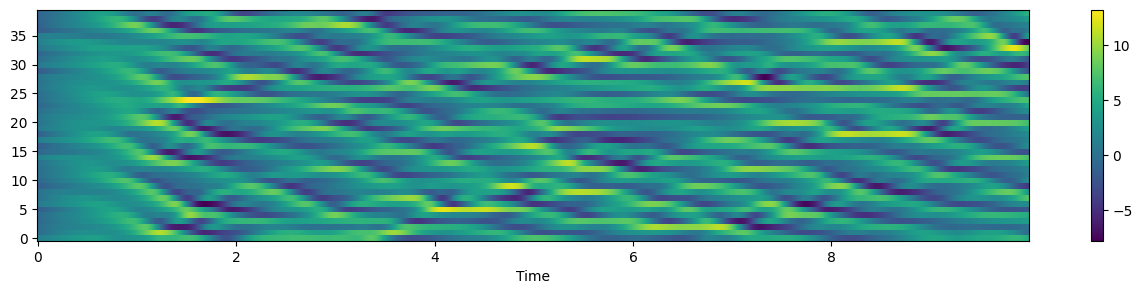

In [ ]:
# Generate a time series from the defined initial_condition using our L96 simulator
forward_operator = L96Simulator(forcing=8.0) # F = 8
ts_length = 1000
time_step = 0.01 # one time step = 0.01 second
forecast_steps = torch.arange(0, ts_length * time_step, time_step)
ts = forward_operator.integrate(time=forecast_steps, state=initial_state.fields['x'].reshape(1, -1)).squeeze()

print(ts.shape)
show_1dseqimg(ts.T, dt=time_step, x_label="Time")

One can see that, for roughly the first second of the forecast, the state is less structured than during the remaining of the time series. This is due to the fact that our sampled initial condition was not taken from the actual stationary distribution of the L96 system. In order to make up for this issue, we will "burn" the first 2 seconds of the time series and actually perform our assimilation on the remaining 8 seconds of data only.

In [ ]:
cutoff_time = 2
cutoff_index = int(cutoff_time / time_step)
true_ts = ts[cutoff_index:]
true_initial_state = true_ts[0]
forecast_steps = torch.arange(0, ts_length * time_step - cutoff_time, time_step)

true_ts = State(true_ts.reshape(1, -1, n_variables), time_axis=forecast_steps)

We now add some Gaussian noise and a binary mask on the true time series, in order to generate corresponding observations.

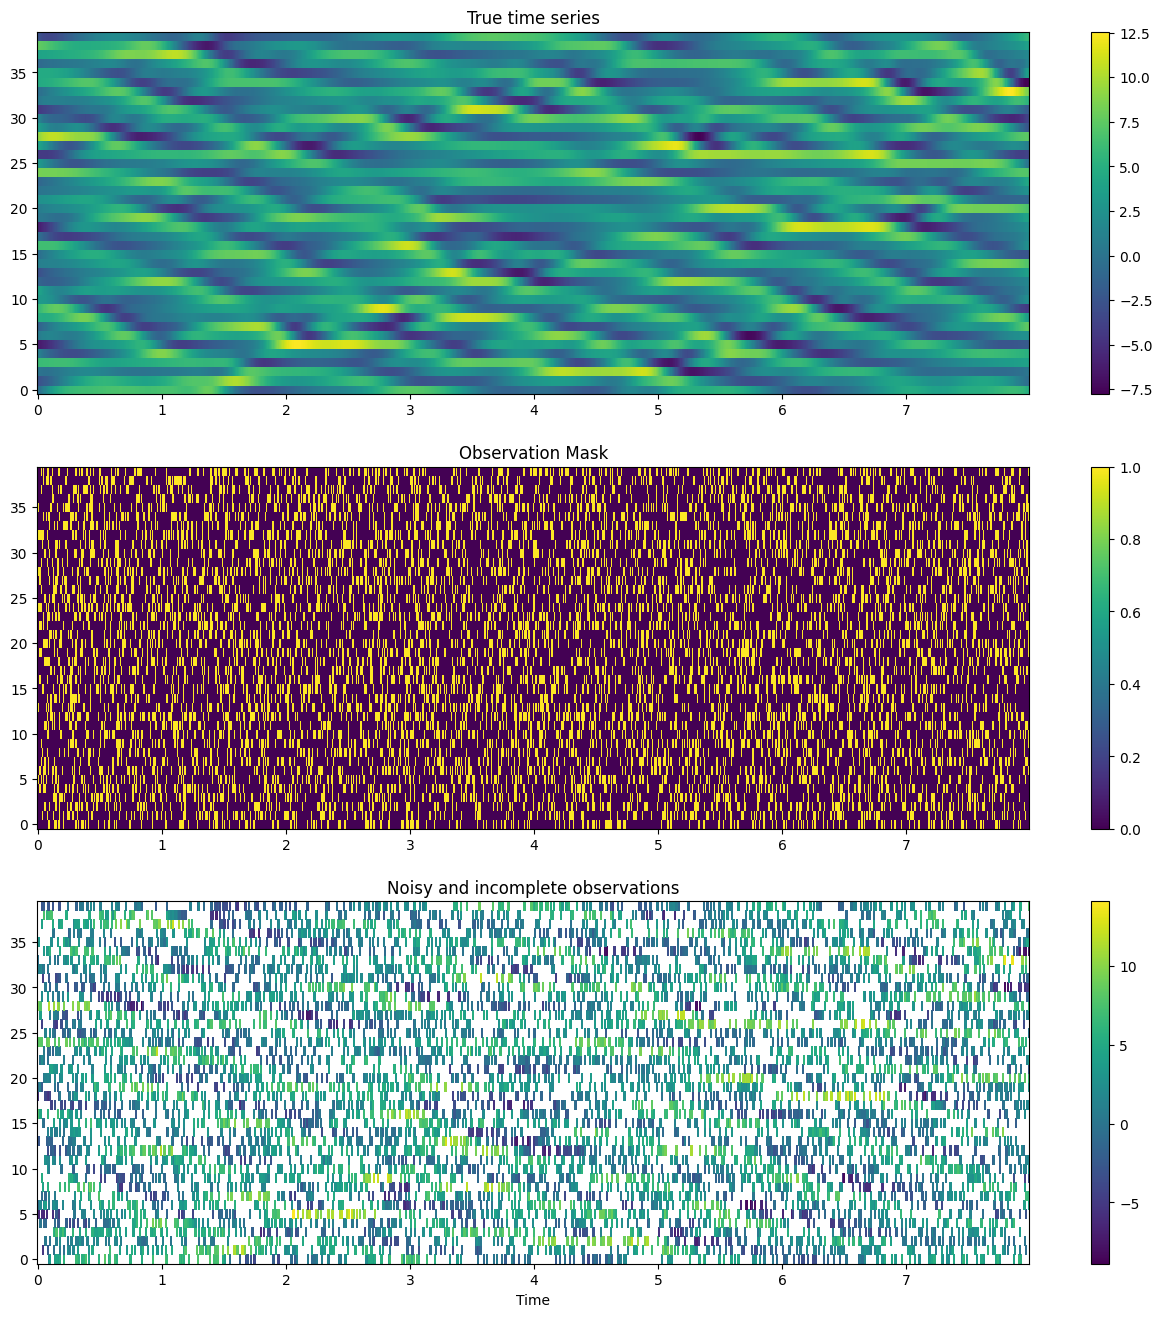

In [ ]:
noise_amplitude = 1.0  # observation noise s.d.
p_obs = 0.25 # 75% of the variables are masked

groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts, noise_amplitude, p_obs)

valid_obs = observations.state.fields['x'][0].T
valid_obs[torch.logical_not(observations.mask.fields['x'][0].T)] = torch.nan

fig, ax = plt.subplots(3, 1, figsize=(16,16))

show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(observations.mask.fields['x'][0].T, dt=time_step, ax=ax[1], title="Observation Mask")
show_1dseqimg(valid_obs, dt=time_step, ax=ax[2], title="Noisy and incomplete observations", x_label="Time")

Let us now implement the strong-constraint 4dvar assimilation scheme to try to reconstruct the full time series from the noisy and incomplete observations.

In [ ]:
# we define a simple one-time-step function in order to fit the da-tools conventions
# In order to use the 4Dvar function, you should always have a function like this taking the state, dt, dynamic_inputs and static_inputs

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    "this time stepping function expects the input State x to have a single field called 'x'"
    B, T = x.fields.batch_size[:2]
    x_tensor = x.fields.reshape(-1)["x"]  # combine batch and time dimensions, leave others intact
    integrated = forward_operator.integrate(torch.arange(2) * dt, x_tensor)[:, 1]
    integrated = integrated.unsqueeze(0)  # re-add batch dimension
    new_fields = TensorDict(x=integrated, batch_size=(1, T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

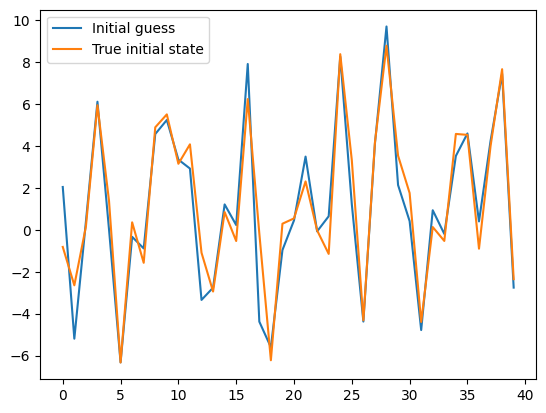

In [ ]:
# we build an initial guess for the initial state, using the available observations
# We simply use the first available observation for each channel
initialization = naive_initialization(observations)  # state estimate for all time points
initialization = initialization[:, :1]  # first time point only

plt.plot(initialization.fields['x'].squeeze(), label='Initial guess')
plt.plot(true_initial_state, label='True initial state')
plt.legend()

In [ ]:
n_obs_steps = 100 # we assimilate only on the earliest time steps, otherwise the optimization would be too unstable
time_window = (observations.state.time_axis[0], observations.state.time_axis[n_obs_steps])

obs_op_opt = obs_op.restrict_time_domain(*time_window)
observations_opt = observations.restrict_time_domain(*time_window)

print(obs_op.mask.fields)

TensorDict(
    fields={
        x: Tensor(shape=torch.Size([1, 800, 40]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([1, 800]),
    device=None,
    is_shared=False)


In [ ]:
t0 = time()
assimilated_ic = hc4dvar_single_window(next_step_function, 
                                       observations_opt, 
                                       obs_op_opt, 
                                       initialization,  
                                       optimizer_pars={'lr': 1e-1})                                     
print(f'Total time for the 4Dvar optimization: {time() - t0} seconds')

Total time for the 4Dvar optimization: 20.08319354057312 seconds


Here we display the assimilated initial state of the trajectory and compare it to the initialization of the 4DVar optimization.

Initial guess MSE: 1.629029631614685
Assimilated state MSE: 0.1248500794172287


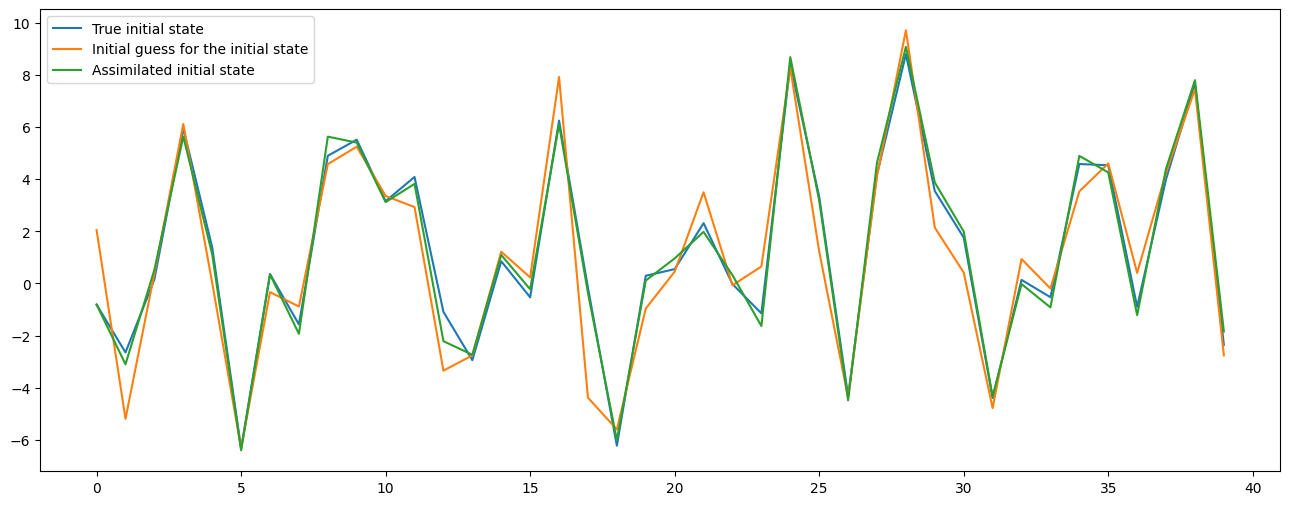

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(true_initial_state, label='True initial state')
plt.plot(initialization.fields['x'].squeeze(), label='Initial guess for the initial state')
plt.plot(assimilated_ic.fields['x'].squeeze().detach(), label='Assimilated initial state')
plt.legend()

MSE0 = torch.mean((initialization.fields['x'].squeeze() - true_initial_state) **2)
MSE = torch.mean((assimilated_ic.fields['x'].squeeze() - true_initial_state) **2)

print(f'Initial guess MSE: {MSE0}')
print(f'Assimilated state MSE: {MSE}')

We finally compute a rollout trajectory from the assimilated initial state and compare it to the groundtruth.

In [ ]:
# rollout from assimilated state
assimilated_trajectory = forward_operator.integrate(time=forecast_steps, state=assimilated_ic.fields['x'][0]).squeeze().cpu().detach()

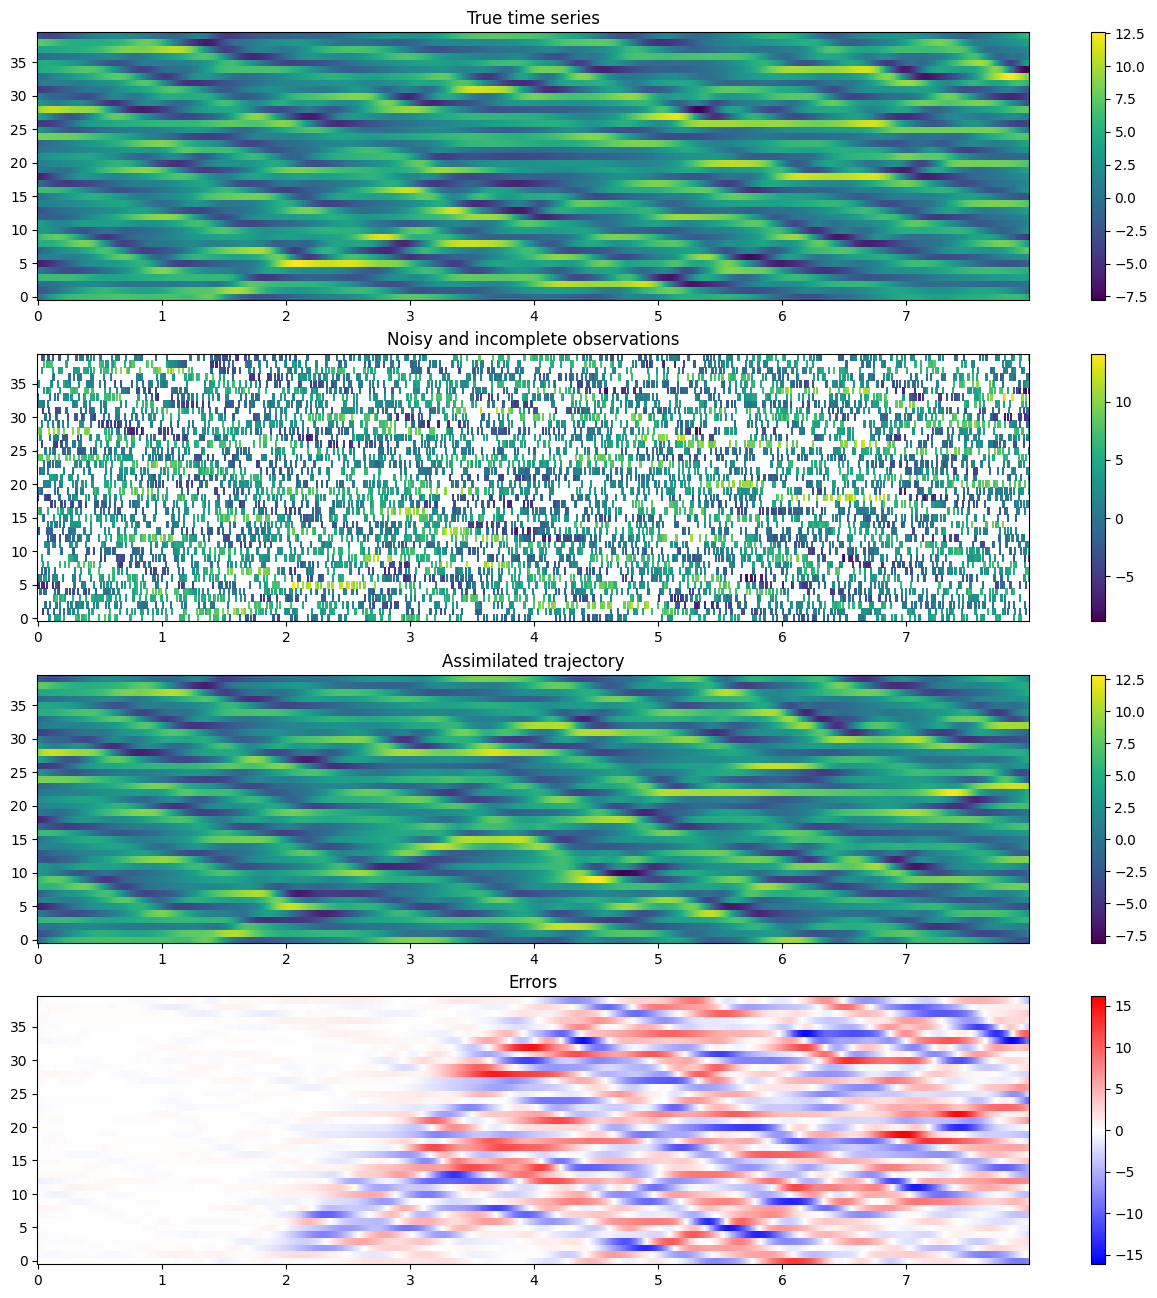

In [ ]:
errors = (assimilated_trajectory - true_ts.fields['x'].squeeze())

fig, ax = plt.subplots(4, 1, figsize=(16,16))
show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(valid_obs, dt=time_step, ax=ax[1], title="Noisy and incomplete observations")
show_1dseqimg(assimilated_trajectory.T, dt=time_step, ax=ax[2], title="Assimilated trajectory")
show_1dseqimg(errors.T, dt=time_step, ax=ax[3], title="Errors", cmap="bwr", center_on_zero=True)

torch.Size([800])


Text(0, 0.5, 'RMSE')

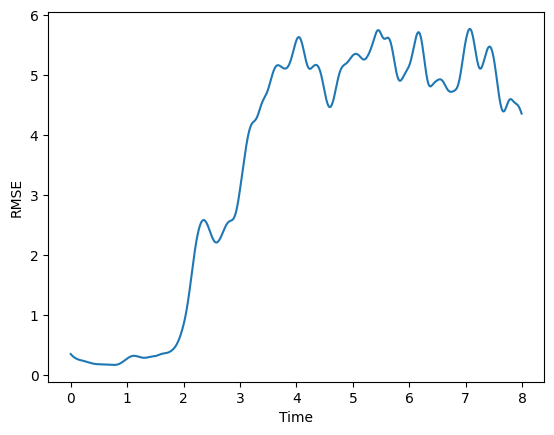

In [ ]:
RMSE_over_time = torch.sqrt((errors ** 2).mean(dim=1))
print(RMSE_over_time.shape)

fig, ax = plt.subplots()
plt.plot(forecast_steps, RMSE_over_time)
ax.set_xlabel('Time')
ax.set_ylabel('RMSE')

After 2 to 3 seconds the RMSE explodes, which is to be expected for a chaotic system like Lorenz-96.